# Ensemble size evaluation with a toy model

In [1]:
import xarray as xr
from climpred.tutorial import load_dataset
import matplotlib.pyplot as plt
import numpy as np

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/xarray/core/dataarray.py:594: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
posx and posy should be finite values


In [2]:
control = load_dataset('MPI-control-1D')['tos'].isel(period=-1, area=1)
# amplitudes of the signal and noise
noise_amplitude = control.std().values * 2.5
signal_amplitude = control.std().values
# period of potentially predictable variable
P = 8

In [3]:
lead = xr.DataArray(np.arange(0, 20, 1), dims='lead')
lead['lead'] = lead.values

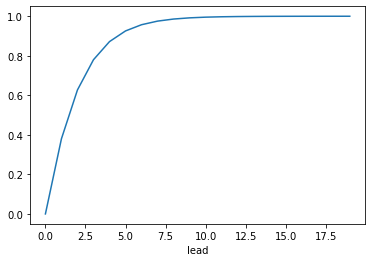

In [4]:
def ramp(t, a=0.2, A_tot=0.5, t_opt=0.1, r=1.8):
    """A weighting function that starts at 0 and approaches 1."""
    A = A_tot * (
        1.0 / (1 + a * np.exp((t_opt - t) / r)) -
        1.0 / (1 + a * np.exp((t_opt) / r))
    )
    A[0] = 0
    A = A / A[-1]
    return A


ramp(lead).plot()

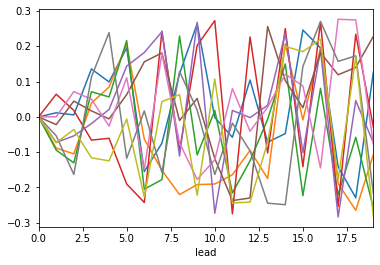

In [5]:
from climpred.toy import create_noise
create_noise(noise_amplitude=noise_amplitude,
             ramp=ramp).to_dataframe('s').unstack().unstack()['s'].plot(legend=False)

## initialize ensemble

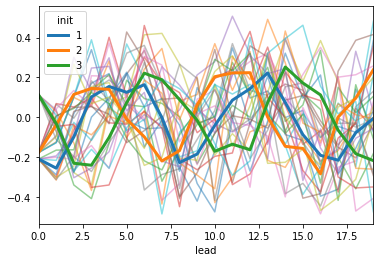

In [84]:
from climpred.toy import create_initialized
i = create_initialized(ninits=3,init_range=210)
i.to_dataframe('s').unstack().unstack().plot(alpha=0.5, legend=False)
i.mean('member').to_dataframe('mean').unstack()[
    'mean'].plot(ax=plt.gca(), lw=3)

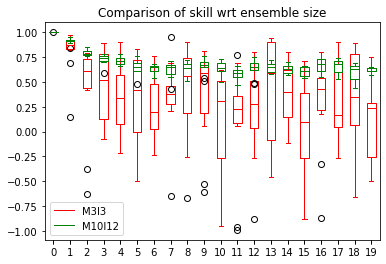

In [7]:
from climpred.toy import run_skill_for_ensemble
metric='pearson_r'
comparison='m2e'
small = run_skill_for_ensemble(nmember=3, ninits=3, metric=metric, comparison=comparison, color='r')
large = run_skill_for_ensemble(ax=plt.gca(),nmember=10, ninits=12, metric=metric, comparison=comparison, color='g')
plt.legend(handles=[small,large],labels=['M3I3','M10I12'])
plt.title('Comparison of skill wrt ensemble size')
plt.show()

Text(0.5, 1.0, '90% Spread for different ensemble sizes')

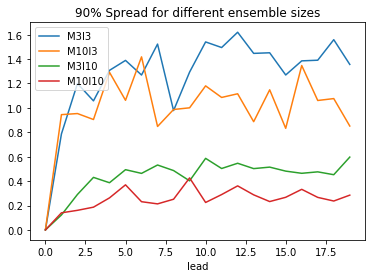

In [19]:
for n in [3,10]:
    for m in [3,10]:
        label=f'M{m}I{n}'
        sig = 0.05
        skill = run_skill_for_ensemble(nmember=m, ninits=n, metric=metric, comparison=comparison, plot=False, bootstrap=50)
        np.abs(skill.quantile(sig,'bootstrap')-skill.quantile(1-sig,'bootstrap')).plot(label=label)
plt.legend()
plt.title('90% Spread for different ensemble sizes')

In [62]:
sig = 0.05
skill_spread = []
inits = [2,3,5,10,20,30,50]
members = [2,3,5,10,20,30,50]
for n in inits:
    s = []
    for m in members:
        label=f'M{m}I{n}'
        skill = run_skill_for_ensemble(nmember=m, ninits=n,
                                       metric=metric,comparison=comparison, plot=False, bootstrap=50).isel(lead=slice(-10,-1))
        s.append(np.abs(skill.quantile(sig,['bootstrap','lead'])-skill.quantile(1-sig,['bootstrap','lead'])))
    ss = xr.concat(s,'member')
    skill_spread.append(ss)
skill_spread = xr.concat(skill_spread,'init')
skill_spread['init']=inits
skill_spread['member']=members

Text(0.5, 1.0, '90% spread in skill')

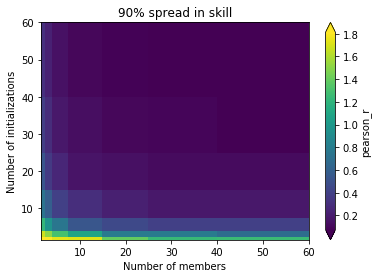

In [63]:
skill_spread.name = metric
skill_spread.plot(robust=True)
plt.ylabel('Number of initializations')
plt.xlabel('Number of members')
plt.title(f'{int((1-2*sig)*100)}% spread in skill')

Text(0.5, 1.0, '5% normalized')

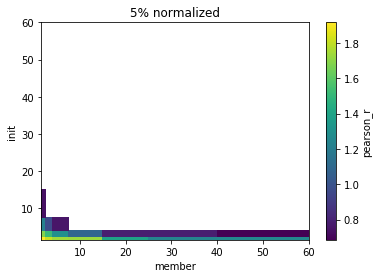

In [69]:
def standardize(ds,dim):
    return (ds-ds.mean(dim))/ds.std(dim)
skill_spread.where(standardize(skill_spread,['init','member'])>.05).plot()
plt.title('5% normalized')

## uninitialize ensemble

In [72]:
from climpred.toy import uninit_ensemble, bootstrap_perfect_model_toy
from climpred.graphics import plot_bootstrapped_skill_over_leadyear

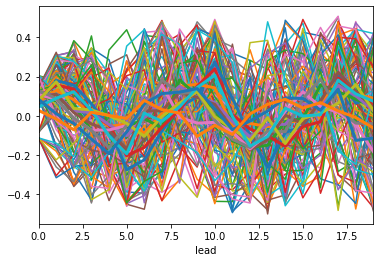

In [80]:
nmember = 10
ninits = 12
ds = create_initialized(nmember=nmember, ninits=ninits)
uninit = uninit_ensemble(ds, ds)
uninit.to_dataframe('s').unstack().unstack(0).plot(legend=False)
uninit.mean('member').to_dataframe('mean').unstack()[
    'mean'].plot(ax=plt.gca(), lw=3,legend=False)

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/xskillscore-0.0.7-py3.6.egg/xskillscore/core/np_deterministic.py:102: RuntimeWarning: Mean of empty slice.
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/xskillscore-0.0.7-py3.6.egg/xskillscore/core/np_deterministic.py:102: RuntimeWarning: Mean of empty slice.
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/xskillscore-0.0.7-py3.6.egg/xskillscore/core/np_deterministic.py:102: RuntimeWarning: Mean of empty slice.
/Users/aaron.spring/anaconda3/envs/climpred-dev/l

Text(0, 0.5, 'rmse')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


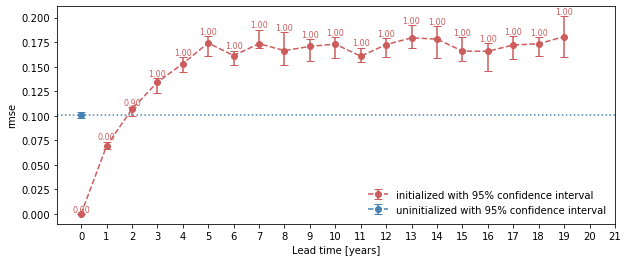

In [82]:
bootstrap = 10
metric='rmse'
# fake reference dataset
fref = ds.rename({'init': 'time'}).isel(lead=0, member=0, drop=True)
bs = bootstrap_perfect_model_toy(ds, fref, metric=metric, bootstrap=bootstrap)
plot_bootstrapped_skill_over_leadyear(bs, sig=95, plot_persistence=False)
plt.ylabel(metric)